<a href="https://colab.research.google.com/github/Donaldwic/Quant/blob/main/Portfolio_Optimization_Using_Black_Litterman_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Black-Litterman Model Formula Overview
The model involves three main steps:

Calculate Implied Equilibrium Returns (Π)

$$ Π=𝛿⋅Σ⋅𝑤 $$

where:


$Π$ is the vector of implied returns,

$δ$ is the risk aversion coefficient,

$Σ$ is the covariance matrix of returns,

$w$ is the vector of market weights.

Investor Views Adjustment The views are incorporated by adjusting the implied returns. Suppose there are $Q$ views with a view matrix $P$ and a view return vector $q$. Then, the adjusted returns $𝜇$ are:
<br>

$$𝜇=(Σ^{-1}+𝑃^{𝑇}Ω^{−1}𝑃)^{−1}⋅(Σ^{−1}Π+𝑃^{𝑇}Ω^{−1}𝑞)$$
where:


$P$ is the matrix representing the views,

$Ω$ is the covariance matrix of the views,

$q$ is the vector of returns based on investor views.
Optimized Portfolio Weights Using the adjusted returns

$μ$, we solve for optimal weights by maximizing the Sharpe ratio through standard mean-variance optimization:

The Black-Litterman model's key advantage is that it allows investors to incorporate their own fundamental views on specific assets or sectors into the portfolio optimization process. <br>Unlike traditional models that rely solely on historical returns, the Black-Litterman model blends these subjective views with the market's equilibrium returns. This means that if an investor has unique insights based on fundamental analysis (e.g., company earnings, economic indicators), they can reflect these insights in the portfolio.

The model also lets investors adjust the confidence level of each view, ensuring a balanced integration with market data. This flexibility leads to a more customized and potentially more accurate portfolio that aligns with both market conditions and investor insights.

# Install Library


In [1]:
pip install pandas numpy scipy matplotlib yfinance cvxpy


# Collect Market Data
* Select a set of assets for your portfolio

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

tickers = ['AAPL', 'MSFT', 'AMZN', 'TSM','LLY','SMCI','PLTR']
start_date = '2022-10-01'
end_date = '2024-10-31'

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
print(data.head())


[*********************100%***********************]  7 of 7 completed

Ticker                           AAPL        AMZN         LLY        MSFT  \
Date                                                                        
2022-10-03 00:00:00+00:00  140.888977  115.879997  315.987122  236.660126   
2022-10-04 00:00:00+00:00  144.498978  121.089996  324.182861  244.662170   
2022-10-05 00:00:00+00:00  144.795654  120.949997  326.040161  244.976761   
2022-10-06 00:00:00+00:00  143.836334  120.300003  327.189941  242.607590   
2022-10-07 00:00:00+00:00  138.554840  114.559998  321.008789  230.270279   

Ticker                     PLTR   SMCI        TSM  
Date                                               
2022-10-03 00:00:00+00:00  8.24  5.707  66.815445  
2022-10-04 00:00:00+00:00  8.46  6.027  70.250282  
2022-10-05 00:00:00+00:00  8.42  6.047  71.861588  
2022-10-06 00:00:00+00:00  8.47  6.145  71.736145  
2022-10-07 00:00:00+00:00  8.15  5.893  67.297874  


# Compute log returns

In [3]:
log_returns = np.log(data / data.shift(1)).dropna()
print(log_returns.head())


Ticker                         AAPL      AMZN       LLY      MSFT      PLTR  \
Date                                                                          
2022-10-04 00:00:00+00:00  0.025300  0.043979  0.025606  0.033253  0.026349   
2022-10-05 00:00:00+00:00  0.002051 -0.001157  0.005713  0.001285 -0.004739   
2022-10-06 00:00:00+00:00 -0.006647 -0.005389  0.003520 -0.009718  0.005921   
2022-10-07 00:00:00+00:00 -0.037410 -0.048890 -0.019072 -0.052192 -0.038513   
2022-10-10 00:00:00+00:00  0.002353 -0.007799 -0.008516 -0.021533 -0.011104   

Ticker                         SMCI       TSM  
Date                                           
2022-10-04 00:00:00+00:00  0.054556  0.050130  
2022-10-05 00:00:00+00:00  0.003313  0.022678  
2022-10-06 00:00:00+00:00  0.016076 -0.001747  
2022-10-07 00:00:00+00:00 -0.041874 -0.063866  
2022-10-10 00:00:00+00:00 -0.046544 -0.033679  


# Calculate Market Equilibrium (CAPM Implied Returns) ($Σ$)

In [4]:
#Estimate the covariance matrix of returns
cov_matrix = log_returns.cov()

# Calculate Market Weight

In [5]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'TSM','LLY','SMCI','PLTR']

# Fetch stock information using yfinance
stock_data = {ticker: yf.Ticker(ticker).info for ticker in tickers}

# Extract market cap and store in a dictionary
market_caps = {ticker: stock_data[ticker]['marketCap'] for ticker in tickers}

# Calculate total market capitalization
total_market_cap = sum(market_caps.values())

# Calculate market weights for each stock
market_weights = {ticker: cap / total_market_cap for ticker, cap in market_caps.items()}
market_weights= np.array(list(market_weights.values()))



In [6]:
market_risk_premium = 0.05
risk_free_rate = 0.015

In [7]:
implied_returns = risk_free_rate + market_risk_premium * np.dot(cov_matrix, market_weights) # calculate the Π
print("Implied Returns: ", implied_returns)


Implied Returns:  [0.01500824 0.01501196 0.01500538 0.01500834 0.01501659 0.01501273
 0.01500822]


# Constructing Matrix 𝑃 & Q
Matrix P Explained
<br>

View 1: AAPL vs. (MSFT + PLTR)
* [1, -0.5, -0.5, 0, 0, 0, 0]
* AAPL is expected to outperform MSFT and PLTR equally.
<br>

View 2: AMZN vs. (TSM + LLY)
* [0, 0, 0, -0.5, 0, -0.5, 1]
* AMZN is expected to outperform TSM and LLY equally.
<br>

View 3: MSFT vs. (PLTR + SMCI + TSM)
* [0, -0.333, 1, 0, -0.333, -0.333, 0]
* MSFT is expected to outperform PLTR, SMCI, and TSM collectively.

Note that; sum of member in matrix for each view is equal 0 and the stock other stocks isn't mentioned is 0

---
Explanation of 𝑄
* Q[0] = 0.03
<br> 3% expected outperformence of AAPL over MSFT and PLTR (1-st view).
* Q[1] = 0.02
<br>2% expected outperformence of AMZN over TSM and LLY (2-nd view).
* Q[2] = 0.025
<br>2.5% expected outperformence of MSFT over PLTR, SMCI, and TSM (3-rd view).


In [8]:
# View matrix P based on hypothetical analyst insights
P = np.array([
    [1, -0.5, -0.5, 0, 0, 0, 0],    # View 1: AAPL expected to outperform MSFT and PLTR
    [0, 0, 0, -0.5, 0, -0.5, 1],    # View 2: AMZN expected to outperform TSM and LLY
    [0, -(1/3), 1, 0, -(1/3), -(1/3), 0]  # View 3: MSFT expected to outperform PLTR, SMCI, and TSM
])


# Views (Expected returns difference)
Q = np.array([0.0001, 0.0002, 0.00005])



# uncertainty (confidence) level about the views ($Ω$)

In [9]:
tau = 0.25 # Scalar (small value indicating uncertainty in the prior)

# Assuming P and cov_matrix (Σ) are defined
PTSigmaP = np.dot(np.dot(P, cov_matrix), P.T)


In [10]:
omega = omega = tau * PTSigmaP
  # Smaller values indicate higher confidence

# Combine Views with Market Equilibrium Using Black-Litterman Model

In [11]:
import numpy as np

# Compute posterior expected returns (Black-Litterman formula)
tau = 0.25  # Scalar (small value indicating uncertainty in the prior)
pi = implied_returns  # Prior

M_inverse = np.linalg.inv(np.dot(np.dot(P.T, np.linalg.inv(omega)), P) + np.linalg.inv(tau * cov_matrix))
adj_returns = M_inverse.dot(np.dot(np.dot(P.T, np.linalg.inv(omega)), Q) + np.linalg.inv(tau * cov_matrix).dot(pi))

print("Adjusted Returns (Black-Litterman):", adj_returns)


Adjusted Returns (Black-Litterman): [0.01503047 0.01498824 0.01497312 0.01500218 0.01500661 0.01486207
 0.01503097]


# Optimize Portfolio Allocation

In [12]:
import cvxpy as cp #library for convex optimization

n = len(tickers)
w = cp.Variable(n)  # Asset weights
gamma = 0.1  # Risk-aversion parameter δ

# Define objective: Maximize risk-adjusted returns
objective = cp.Maximize(adj_returns.T @ w - gamma * cp.quad_form(w, cov_matrix))

# Constraints: Weights sum to 1 and are non-negative
constraints = [cp.sum(w) == 1, w >= 0]

# Solve optimization problem
prob = cp.Problem(objective, constraints)
prob.solve()

print("Optimal Weights:", w.value)


Optimal Weights: [ 7.98617016e-01 -1.09849220e-20 -1.47441734e-20 -1.37298610e-20
 -4.72104259e-21  1.74343841e-20  2.01382984e-01]


# Visualize the Optimal Portfolio

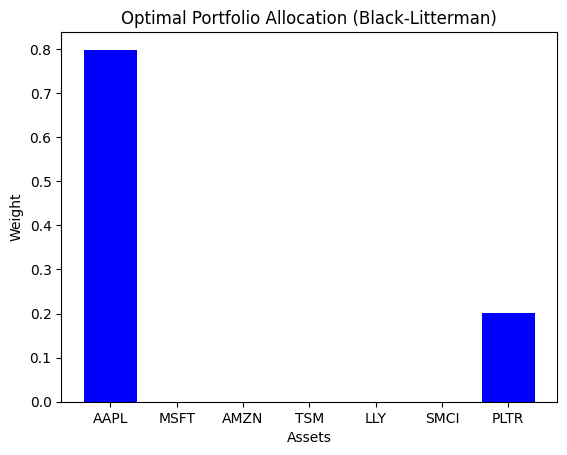

In [13]:
import matplotlib.pyplot as plt

plt.bar(tickers, w.value, color='blue')
plt.title('Optimal Portfolio Allocation (Black-Litterman)')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.show()


In [14]:
import matplotlib.pyplot as plt

optimal_weights = w.value  # Optimal weights from the optimization
percentage_allocations = optimal_weights * 100  # Convert to percentage

# Print out each asset's percentage allocation
for ticker, allocation in zip(tickers, percentage_allocations):
    print(f"{ticker}: {allocation:.2f}%")


AAPL: 79.86%
MSFT: -0.00%
AMZN: -0.00%
TSM: -0.00%
LLY: -0.00%
SMCI: 0.00%
PLTR: 20.14%


# Backtest the Portfolio Performance

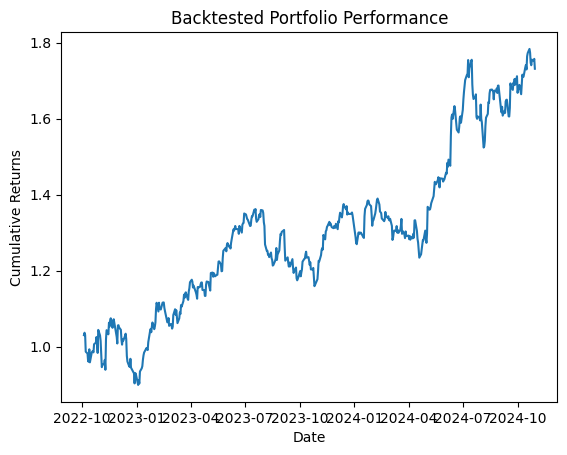

Total Percentage Gain: 73.14%


In [15]:
portfolio_returns = log_returns.dot(w.value)
cumulative_returns = (1 + portfolio_returns).cumprod()

total_percentage_gain = (cumulative_returns.iloc[-1] - 1) * 100


plt.plot(cumulative_returns)
plt.title('Backtested Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()
print(f"Total Percentage Gain: {total_percentage_gain:.2f}%")
